In [16]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from pandas import datetime
import os
import time
import warnings
import numpy as np
from numpy import newaxis
import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import pyedflib
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy Numpy warnings

# create a differenced series
def difference(dataset, interval=1):
    diff = np.zeros((dataset.shape[0],dataset.shape[1]))
    for k in range(dataset.shape[0]):
        for i in range(interval, dataset.shape[1]):
            diff[k,i] = dataset[k,i] - dataset[k,i - interval]
            
    return diff

# scale train and test data to [-1, 1]
def scale_t(data):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data = data.reshape(-1, 1)
    #scaler = StandardScaler()
    scaler = scaler.fit(data)
    # transform data
    print(data.shape[0])
    
    data_scaled = scaler.transform(data)
    
    return scaler, data_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

def load_data(filename):
    g = pyedflib.EdfReader(filename)
    n = g.signals_in_file
    signal_labels = g.getSignalLabels()
    sig = np.zeros((n, g.getNSamples()[0]))
    for i in np.arange(n):
        len_sig = len(g.readSignal(i))
        sig[i, :len_sig] = g.readSignal(i)
    return sig
def make_data(sig, seq_len, normalise_window):
    

    data = sig[:3,:10000]
    data_scale = np.zeros(data.shape)
    for i in range(data.shape[0]):
        scaler, data_s = scale_t(data[i])
        data_scale[i] = data_s[:,0]
    if not normalise_window:
        diff = difference(data_scale,1)
    plt.plot(range(len(sig[0,:50])), sig[0,:50])
    plt.show()
    plt.plot(range(len(data_scale[0, :50])), data_scale[0, :50])
    plt.show()
    plt.plot(range(len(diff[0,:50])), diff[0,:50])
    plt.show()
    sequence_length = seq_len + 1
    
    result = np.zeros((diff.shape[0],diff.shape[1] - sequence_length, sequence_length))
    for index in range(diff.shape[1] - sequence_length):
        for k in range(diff.shape[0]):
            result[k,index] = diff[k,index: index + sequence_length]
    #print result[:,0]
    if normalise_window:
        result = normalise_windows(result)
    
    row = round(0.9 * result.shape[1])
    
    train = result[:,:int(row), :]
    test = result[:,int(row):, :]
    
    
    #print(train_scaled.shape,test_scaled.shape)  
    #print(train_scaled[0],test_scaled[0])
    #np.random.shuffle(train)
    old_x_train = train[:,:, :-1]
    y_train = train[:,:, -1]
    old_x_test = test[:,:, :-1]
    y_test = test[:,:, -1]

    x_train = np.zeros((old_x_train.shape[1], old_x_train.shape[2], old_x_train.shape[0]))
    for i in range(old_x_train.shape[1]):
        for k in range(old_x_train.shape[2]):
            vals = np.zeros(old_x_train.shape[0])
            for index in range(old_x_train.shape[0]):
                vals[index] = old_x_train[index,i,k]
                #print vals
            x_train[i,k] = vals
    
    x_test = np.zeros((old_x_test.shape[1], old_x_test.shape[2], old_x_test.shape[0]))
    for i in range(old_x_test.shape[1]):
        for k in range(old_x_test.shape[2]):
            vals = np.zeros(old_x_test.shape[0])
            for index in range(old_x_test.shape[0]):
                vals[index] = old_x_test[index,i,k]
            x_test[i,k] = vals

    return [scaler, x_train, y_train.T, x_test, y_test.T]

In [17]:
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data
        
def build_model(layers):
    model = Sequential()
    print(layers)
    model.add(LSTM(
        input_shape=(layers[1], layers[0]),
        output_dim=layers[3],
        return_sequences=True))
    #model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=True))
    #model.add(Dropout(0.2))
    
    model.add(LSTM(
        layers[2],
        return_sequences=True))
    #model.add(Dropout(0.2))
    
    model.add(LSTM(
        layers[2],
        return_sequences=False))
    #model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss='mean_absolute_error', optimizer='adam')
    print("> Compilation Time : ", time.time() - start)
    return model



In [18]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.acc = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))

In [19]:
def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    #predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [20]:
import time
import matplotlib.pyplot as plt

def plot_results(predicted_data, true_data, make_line):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    if make_line:
        plt.axvline(x=y_train.shape[0] + 1, linestyle='--', color = 'b', label = 'future predicted points')
    plt.show()

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

In [21]:
global_start_time = time.time()
seq_len = 50

print('> Loading data... ')
sig = load_data('sample-data/SC4001E0-PSG.edf')




> Loading data... 


10000
10000
10000


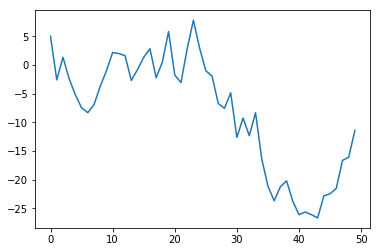

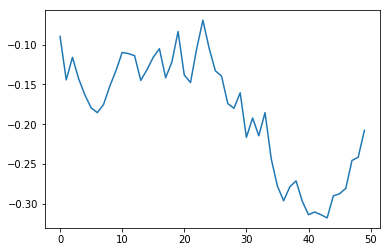

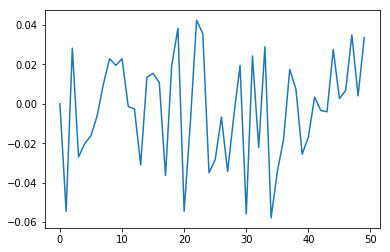

((8954, 50, 3), (8954, 3), (995, 50, 3), (995, 3))


In [22]:
scalers, X_train, y_train, X_test, y_test = make_data(sig, seq_len, False)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [23]:
print('> Data Loaded. Compiling...')
epochs  = 50
model = build_model([X_train.shape[2], X_train.shape[1], 100, X_train.shape[2]])
history = LossHistory()
filepath = 'save_model/weights_{epoch:02d}_no_drop.hdf5'
save_model = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=50)
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None)

#history = keras.callbacks.Callback()
model.fit(X_train, y_train, batch_size=800, nb_epoch=epochs, validation_split=0.05, callbacks=[history, save_model])

#predictions = lstm.predict_sequences_multiple(model, X_test, seq_len, 50)
#predicted = lstm.predict_sequence_full(model, X_test, seq_len)


> Data Loaded. Compiling...
[3, 50, 100, 3]
('> Compilation Time : ', 0.02489304542541504)
Train on 8506 samples, validate on 448 samples
Epoch 1/50
8506/8506 [==============================] - 24s 3ms/step - loss: 0.0615 - val_loss: 0.0674
Epoch 2/50
8506/8506 [==============================] - 20s 2ms/step - loss: 0.0614 - val_loss: 0.0673
Epoch 3/50
8506/8506 [==============================] - 21s 2ms/step - loss: 0.0613 - val_loss: 0.0670
Epoch 4/50
8506/8506 [==============================] - 20s 2ms/step - loss: 0.0611 - val_loss: 0.0662
Epoch 5/50
8506/8506 [==============================] - 21s 2ms/step - loss: 0.0609 - val_loss: 0.0642
Epoch 6/50
8506/8506 [==============================] - 20s 2ms/step - loss: 0.0603 - val_loss: 0.0606
Epoch 7/50
8506/8506 [==============================] - 20s 2ms/step - loss: 0.0598 - val_loss: 0.0607
Epoch 8/50
8506/8506 [==============================] - 20s 2ms/step - loss: 0.0597 - val_loss: 0.0619
Epoch 9/50
8506/8506 [================

(8954, 3)
('Training duration (s) : ', 983.6181211471558)
(995, 3)


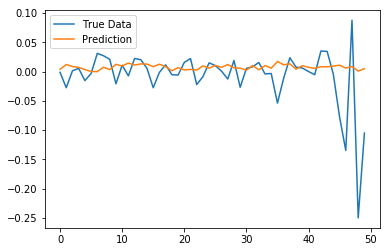

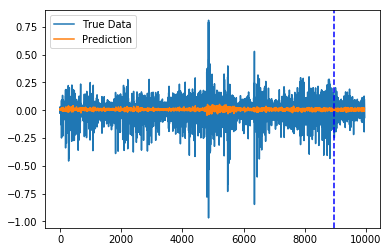

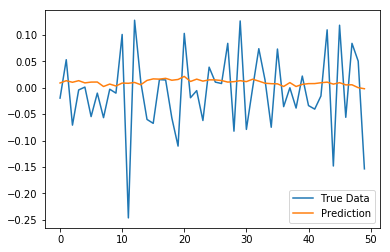

(8954, 3)
('Training duration (s) : ', 995.1946551799774)
(995, 3)


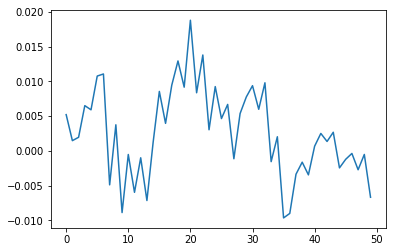

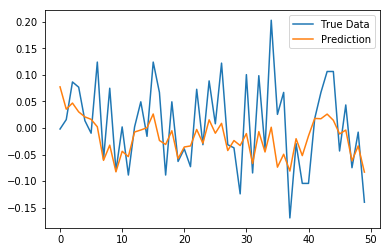

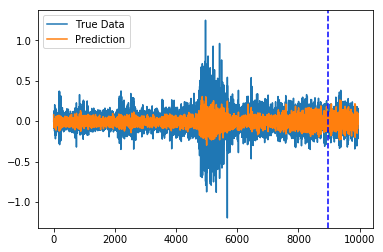

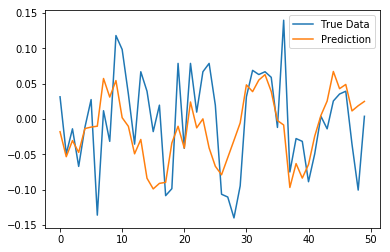

(8954, 3)
('Training duration (s) : ', 1006.8377070426941)
(995, 3)


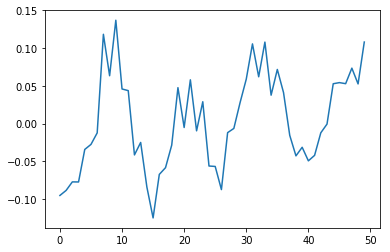

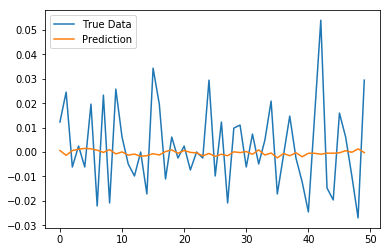

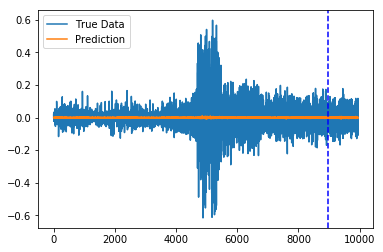

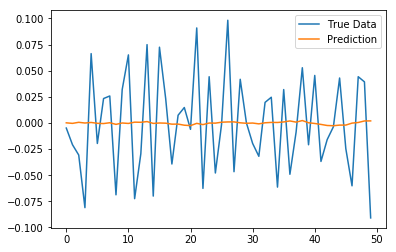

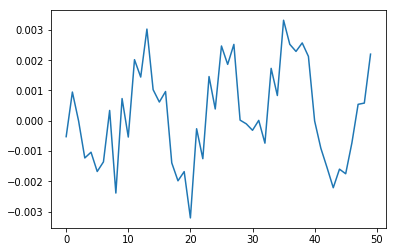

In [24]:
from keras.models import load_model
#model = load_model('save_model/weights_50.hdf5')

for i in range(X_train.shape[2]):
    predicted_test = predict_point_by_point(model, X_test)        
    predicted_train = predict_point_by_point(model, X_train)
    print(predicted_train.shape)
    print('Training duration (s) : ', time.time() - global_start_time)
    print predicted_test.shape
    
    plot_results(predicted_train[:50, i], y_train[:50,i], False)
    true_data = np.concatenate([y_train[:,i],y_test[:,i]])
    pred_data = np.concatenate([predicted_train[:,i],predicted_test[:,i]])
    plot_results(pred_data, true_data, True)
    plot_results(predicted_test[:50,i], y_test[:50,i], False)
    
    plt.plot(predicted_test[:50,i] - predicted_train[:50, i])

   

In [25]:
print(X_test[:100,:,0] - X_train[:100,:,0])

[[-0.00134862  0.06203641 -0.04450438 ... -0.02899528 -0.01618341
   0.01078894]
 [ 0.06203641 -0.04450438 -0.01213756 ... -0.01618341  0.01078894
  -0.01820634]
 [-0.04450438 -0.01213756  0.13216453 ...  0.01078894 -0.01820634
   0.08091706]
 ...
 [-0.00337154  0.30074174 -0.04855024 ...  0.34861767  0.00067431
   0.10586649]
 [ 0.30074174 -0.04855024  0.20364127 ...  0.00067431  0.10586649
   0.15441672]
 [-0.04855024  0.20364127 -0.06001349 ...  0.10586649  0.15441672
   0.17262306]]


In [26]:
for layer in model.layers:
    weights = np.array(layer.get_weights())
    print weights.shape

(3,)
(3,)
(3,)
(3,)
(2,)
(0,)


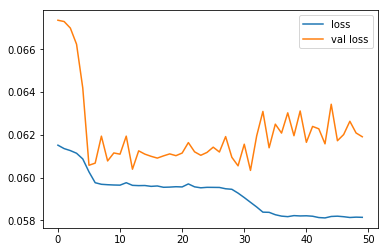

In [27]:
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(range(len(history.losses)),(np.array(history.losses)), label='loss')
plt.plot(range(len(history.val_losses)),(np.array(history.val_losses)), label='val loss') 
plt.legend()
plt.show()

In [28]:
predicted = lstm.predict_sequences_multiple(model, X_test, seq_len, 50)
predicted_train = lstm.predict_sequences_multiple(model, X_train, seq_len, 50)
plot_results(predicted_train[:50], y_train[:50], False)
plot_results(np.concatenate([predicted_train,predicted]), np.concatenate([y_train,y_test]), True)
plot_results_multiple(predicted[:50], y_test[:50], 50, False)

NameError: name 'lstm' is not defined

In [ ]:
predicted = lstm.predict_sequence_full(model, X_test, seq_len)
predicted_train = lstm.predict_sequence_full(model, X_train, seq_len)

In [ ]:
Fs = 100
T = len(true_data)/Fs
N = Fs*T
    
true_data_w = np.fft.fft(true_data)/N
power_true_data = abs(true_data_w)**2

pred_data_w = np.fft.fft(pred_data)/N
power_pred_data = abs(pred_data_w)**2
w = np.arange(0,Fs,1/T)
plt.plot(w[:int(N/2)], power_true_data[:int(N/2)])
plt.ylabel('Power')
plt.xlabel('frequency (f)')
plt.title('Power spectrum')
plt.plot(w[:int(N/2)], power_pred_data[:int(N/2)])
plt.show()
plt.show()